# <center>Statistical Inference on Properties of Red and White Wine</center>
#### **Authors:** Longfei Guan, Omer Tahir, Paul Huang, Sam Zheng
#### **Group:** 9

## 1. Introduction

Substance testing takes on many practical applications in modern society, whether it be forensics, sports integrity, or medicinal research. Distinguishing and determining the presence of substances is undoubtedly an essential technique in improving society that draws upon many scientific disciplines namely chemistry and statistics. 
  
Acknowledging the diversity of modern techniques which can vary in context and application, this report aims to use statistical inference to differentiate two groups of wine - red and white. Evidently, in a real-life scenario, this would be as simple as a color comparison; however, the goal is to prove potential discrepancies in qualities that can be statistically inferred between unknown substances. 
<p align="center">
  <img src = "https://img.onmanorama.com/content/dam/mm/en/food/in-season/images/2019/11/8/wine.jpg" width = "500"/>
  <img src = "https://learn.winecoolerdirect.com/wp-content/uploads/2020/04/Red-and-White-Wine-opt.jpg" width = "500"/>
</p>

The data set which will be used is the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality) from UCI machine learning repository. Of the variables, below are the three of interest (Refer to 2.1.3 for variable analysis).
* `Volatile acidity (VA)`: One of the chemicals produced during the production smells and tastes like vinegar. Many countries have set VA concentration limits in order to assure the quality of the wine.
* `Alcohol Content`: A key element that explains the rich flavours and tastes of wines. It can make wine taste bitter, sour, sweet, and spicy.
* `Total Sulfur Dioxide`: Mainly added to kill bacteria and prevent oxidation of the wine. 
  
Likewise, our research question is:

#### _<center>Does alcohol, sulfur dioxide, and volatile acidity differ between red and white wine?</center>_

## 2. Method and Results

### 2.1.1 Loading relevant libraries

In [39]:
library(tidyverse)
library(infer)         # helps us use the infer workflow for virtual sampling
library(ggcorrplot)    # imports the function to create the correlation plot
library(knitr)         # helps make tidy markdown tables
library(grid)          # helps organize multiple plots together
library(pdp)           

### 2.1.2 Reading & Wrangling the datasets from the web into R

* Since we were dealing with 2 data sets, it is decided to read both the data sets separately and then merge them into a single dataframe called `wine_data`.
* Before merging, a new column is created called `type` in order to differentiate the white wine data with the red wine after the merge.
* After merging, the `type` and `quality` variables are converted into a factor as these are categorical/discrete variables.


In [40]:
# prepare urls
url_1 <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
url_2 <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

# read redwine data
redwine_data <- 
    read.csv(url_1, sep=';') |>
    mutate(type = "red")

# read whitewine data
whitewine_data <- 
    read.csv(url_2, sep=';') |>
    mutate(type = "white")

# merge the two data sets using rbind()
wine_data <-  
    rbind(redwine_data, whitewine_data) |> 
    select(type, fixed.acidity:quality) |>
    mutate(quality = as_factor(quality),
           type = as_factor(type))

<center>Table 1: Wine Data</center>

|type | fixed.acidity| volatile.acidity| citric.acid| residual.sugar| chlorides| free.sulfur.dioxide| total.sulfur.dioxide| density|   pH| sulphates| alcohol|quality |
|:----|-------------:|----------------:|-----------:|--------------:|---------:|-------------------:|--------------------:|-------:|----:|---------:|-------:|:-------|
|red  |           7.4|             0.70|        0.00|            1.9|     0.076|                  11|                   34|  0.9978| 3.51|      0.56|     9.4|5       |
|red  |           7.8|             0.88|        0.00|            2.6|     0.098|                  25|                   67|  0.9968| 3.20|      0.68|     9.8|5       |
|red  |           7.8|             0.76|        0.04|            2.3|     0.092|                  15|                   54|  0.9970| 3.26|      0.65|     9.8|5       |
|red  |          11.2|             0.28|        0.56|            1.9|     0.075|                  17|                   60|  0.9980| 3.16|      0.58|     9.8|6       |
|red  |           7.4|             0.70|        0.00|            1.9|     0.076|                  11|                   34|  0.9978| 3.51|      0.56|     9.4|5       |
|red  |           7.4|             0.66|        0.00|            1.8|     0.075|                  13|                   40|  0.9978| 3.51|      0.56|     9.4|5       |

### 2.1.3 Exploratory Data Analysis

* We begin by checking for correlations for all the variables.
* This will help us visualize how the 3 variables we plan on using are related to the `type` variable.
* A custom function `to_binary()` is defined in order to convert the categorical variable `type` of wine into a binary variable.
* This is done as the `ggcorrplot()` function takes binary input instead of a categorical variable.

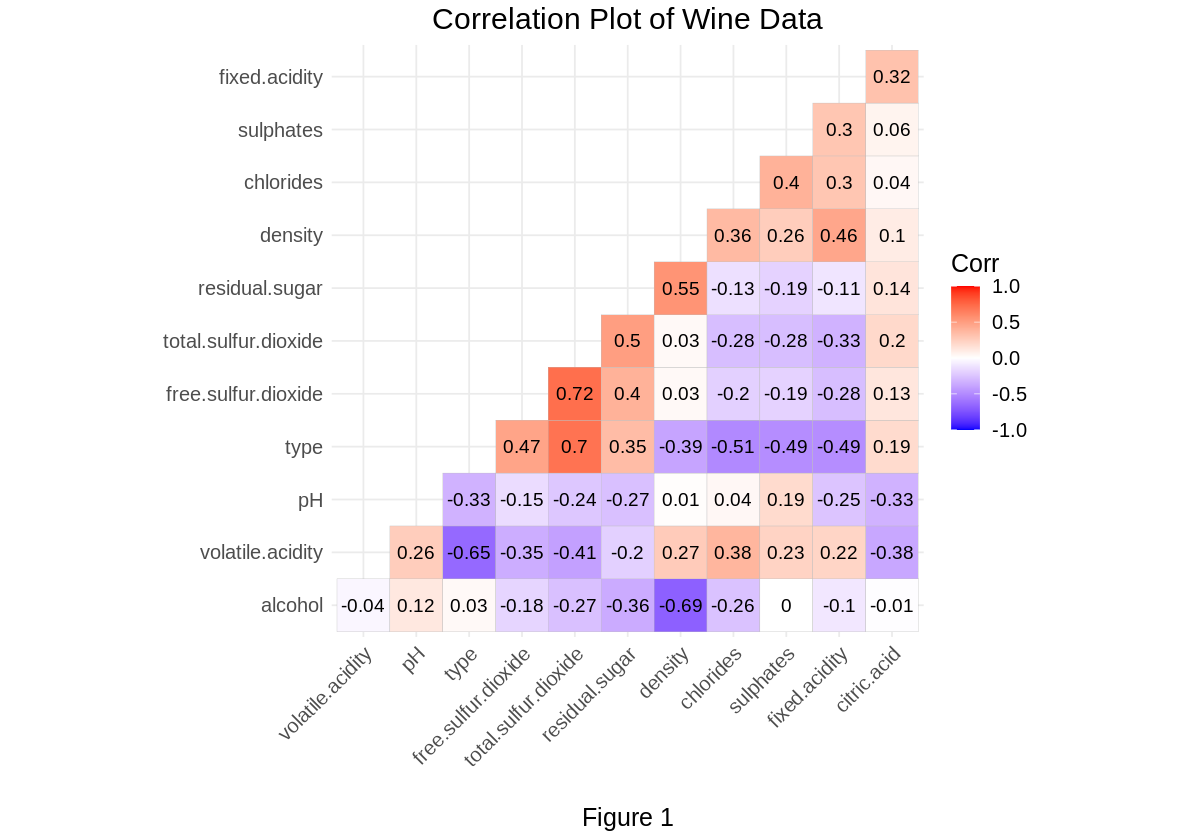

In [41]:
options(repr.plot.width = 10, repr.plot.height = 7)

# Convert categorical variable to binary (needed to make ggorrplot() work)
to_binary <- function(x) {
    if(x == "red") {
        return(0)
    } else {
        return(1)
    }
}

# Prepare data for correlation plot
r <- wine_data |>
    mutate(type = sapply(wine_data$type, to_binary)) |>
    select(type:alcohol) |>
    cor(use="complete.obs")|> 
    round(2)

# Visualize the correlations across all the variables
ggcorrplot(r, 
           hc.order = TRUE, 
           type = "lower",
           lab = TRUE) +
    labs(title = "Correlation Plot of Wine Data",
         caption = "\nFigure 1") +
    theme(text = element_text(size = 15),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 15, hjust = 0.5))

* Figure 1 shows us that `alcohol` has little to no correlation with `type`. On the other hand, `total.sulfur.dioxide` has the largest positive correlations with `type` while `volatile.acidity` has the largest negative correlations with `type`. This further convinces us that at least two of the three selected variables must be further analyzed as the different type of wine may have a significantly different composition based on these variables.

* Now we check to see how each of these selected variable is distributed across each type of wine.
* With the help of histograms, we can visualize these distributions.

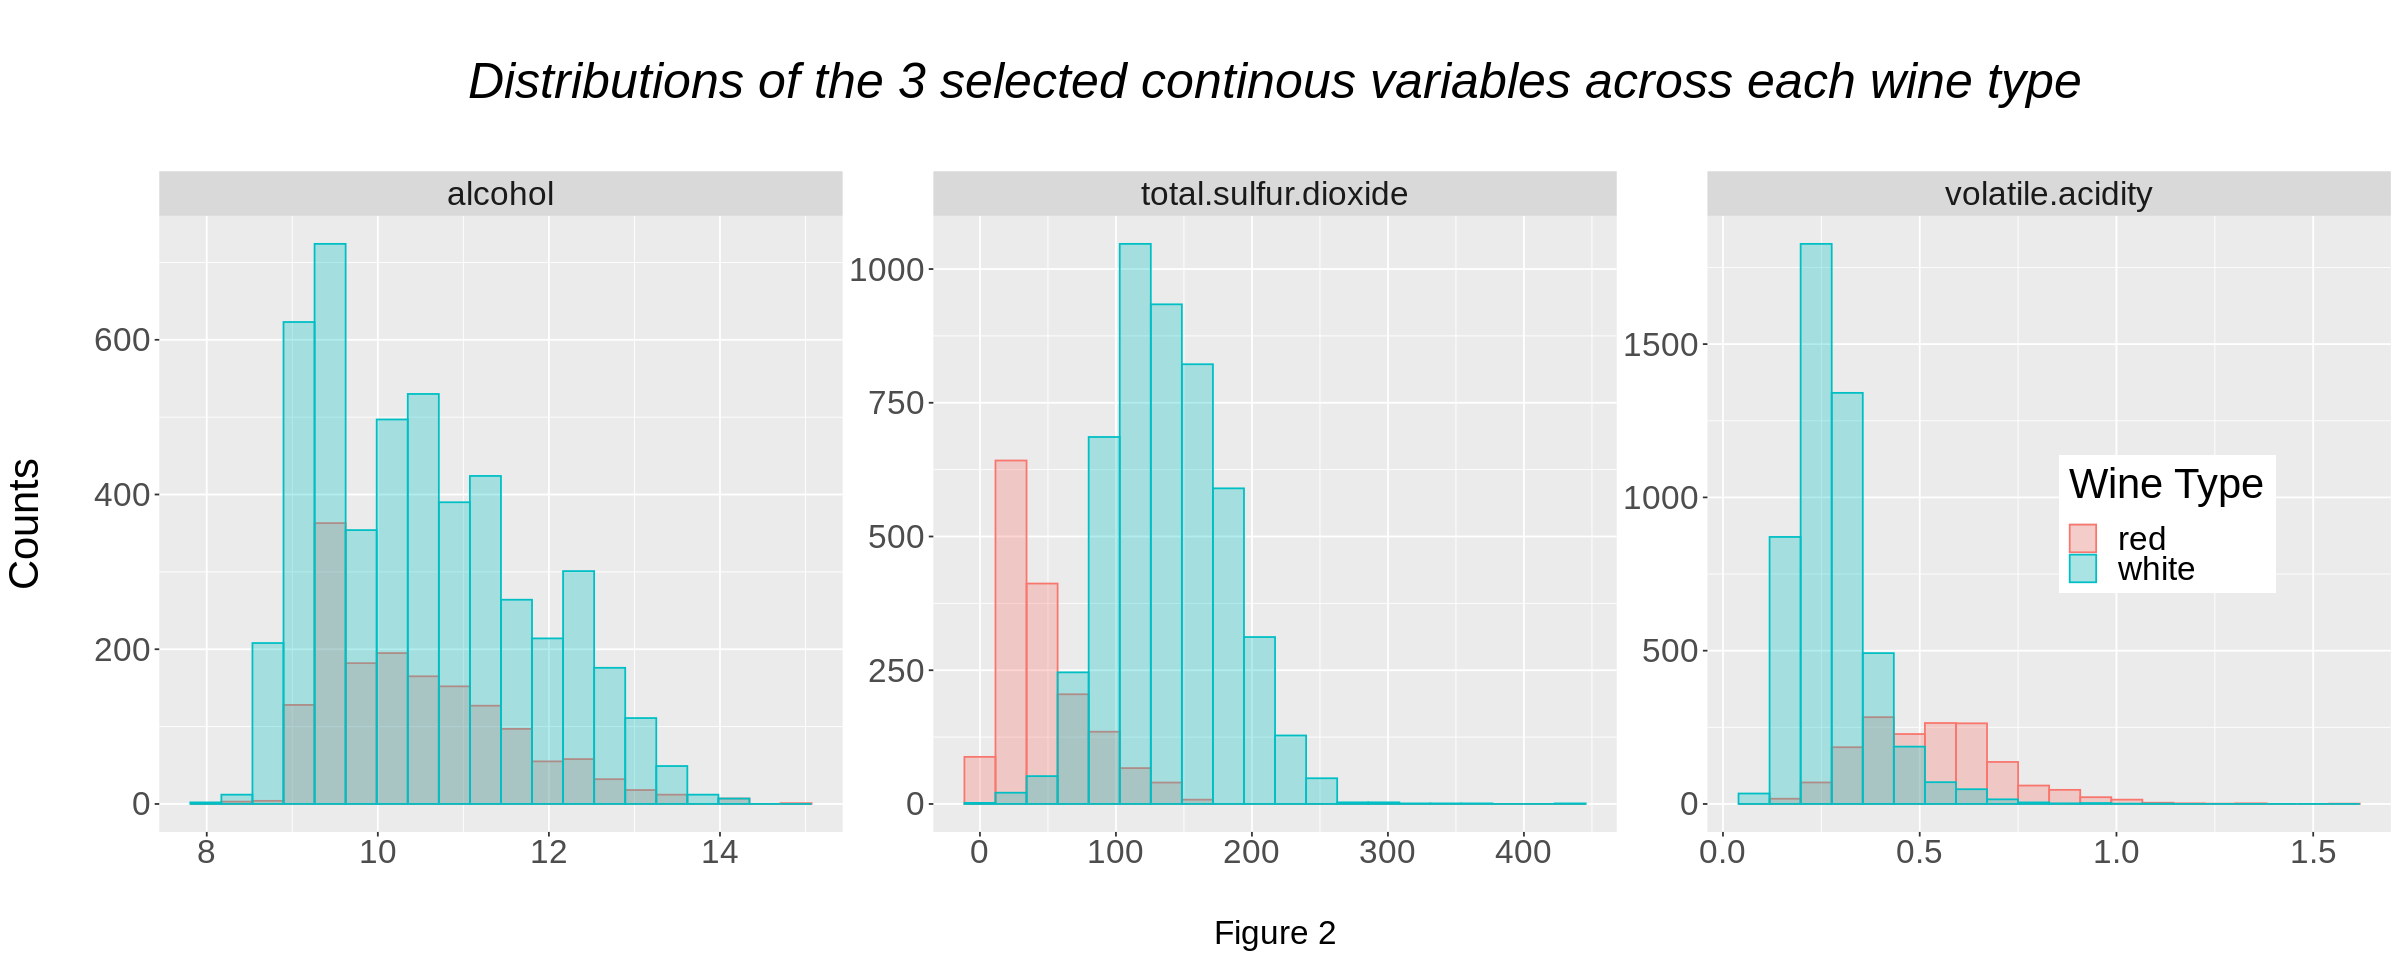

In [42]:
options(repr.plot.width = 20, repr.plot.height = 8)

# Visualize the sample distributions of the 3 selected variables
wine_data |> 
    select(type,
           alcohol,
           total.sulfur.dioxide,
           volatile.acidity) |>
    pivot_longer(cols = -type,
                names_to = "response",
                values_to = "values") |>
    ggplot(aes(x = values, fill = type, colour = type)) +
    geom_histogram(alpha = 0.3, position = 'identity', bins = 20) +
    labs(x = "",
         y = "Counts\n",
         fill = "Wine Type",
         colour = "Wine Type",
         title = "\nDistributions of the 3 selected continous variables across each wine type\n",
         caption = "Figure 2") +
    facet_wrap(vars(response),
               scales = "free") +
    theme(text = element_text(size = 25),
          plot.title = element_text(hjust = 0.5, face = "italic"),
          plot.caption = element_text(hjust = 0.5),
          legend.position = c(0.90, 0.50))

* Since we want to check how each of these variables responds to the type of wine, we choose the expected difference as the parameter to be estimated.

### 2.1.4 Descriptive Statistics

* We first define a tibble with the names of all the response variables.
* Now we calculate statistics such as the mean, median, variance and standard deviation for each of the response variables and store it inside a data frame called `stats`.
    - Since we want to calculate these statistics for each wine type and each response, `pivot_longer` transforms the data to help us group by `type` and `Response` and `summarise()` to calculate each of the mentioned statistic.
    - We transform the data again by using `pivot_wider()` this time to have separate columns for statistics associated with `red` wine and `white` wine.
    - Finally, we re-order all the columns.
* Another data frame with the same statistics is created but the values are rounded off for a better visual representation of the descriptive statistics. This is assigned to the object `summary_stats()`.

In [43]:
# Create a tibble with the names of all the response variables
names <- 
  tibble(response_variables = c("Alcohol Content",
                                "Total Sulfur Dioxide",
                                "Volatile Acidity"))

# Calculate statistics (mean, median, variance, standard deviation) for each selected response variable
stats <-
    wine_data |>
    select(type, alcohol, total.sulfur.dioxide, volatile.acidity) |>
    pivot_longer(cols = c(-type),
                 names_to = "Response",
                 values_to = "Value") |>
    group_by(type, Response) |>
    summarise(n = n(),
              mean = mean(Value, na.rm = TRUE),
              var = var(Value, na.rm = TRUE),
              sd = sd(Value, na.rm = TRUE),
              median = median(Value, na.rm = TRUE)) |>
    pivot_wider(names_from = type,
                values_from = c(n, mean, var, sd, median)) |>
    select(c(1,2,4,6,8,10,3,5,7,9,11))

# Display some of the important statistics in a tidy table
summary_stats <- 
    stats |>
    select(Response,
           n_red, mean_red, sd_red, median_red,
           n_white, mean_white, sd_white, median_white) |>
    mutate_at(vars(starts_with(c("mean", "sd", "median"))), 
            function(x) format(round(x, 2), nsmall = 2)) |> 
    mutate(sd_red = sapply(sd_red, function(x) paste0("(", x, ")")),
           sd_white = sapply(sd_white, function(x) paste0("(", x, ")")))

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.


<table class="table" style="margin-left: auto; margin-right: auto;border-bottom: 0;">
<caption><center>Table 2: Descriptive statistics</center></caption>
 <thead>
<tr>
<th style="empty-cells: hide;border-bottom:hidden;" colspan="1"></th>
<th style="border-bottom:hidden;padding-bottom:0; padding-left:3px;padding-right:3px;text-align: center; font-weight: bold; font-style: italic; " colspan="4"><div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">Red Wine</div></th>
<th style="border-bottom:hidden;padding-bottom:0; padding-left:3px;padding-right:3px;text-align: center; font-weight: bold; font-style: italic; " colspan="4"><div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">White Wine</div></th>
</tr>
  <tr>
   <th style="text-align:left;"> Response Variable </th>
   <th style="text-align:right;"> n </th>
   <th style="text-align:right;"> Mean </th>
   <th style="text-align:left;"> (SD) </th>
   <th style="text-align:right;"> Median </th>
   <th style="text-align:right;"> n </th>
   <th style="text-align:right;"> Mean </th>
   <th style="text-align:left;"> (SD) </th>
   <th style="text-align:right;"> Median </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> Alcohol Content </td>
   <td style="text-align:right;"> 1599 </td>
   <td style="text-align:right;"> 10.42 </td>
   <td style="text-align:left;"> ( 1.07) </td>
   <td style="text-align:right;"> 10.20 </td>
   <td style="text-align:right;"> 4898 </td>
   <td style="text-align:right;"> 10.51 </td>
   <td style="text-align:left;"> ( 1.23) </td>
   <td style="text-align:right;"> 10.40 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Total Sulfur Dioxide </td>
   <td style="text-align:right;"> 1599 </td>
   <td style="text-align:right;"> 46.47 </td>
   <td style="text-align:left;"> (32.90) </td>
   <td style="text-align:right;"> 38.00 </td>
   <td style="text-align:right;"> 4898 </td>
   <td style="text-align:right;"> 138.36 </td>
   <td style="text-align:left;"> (42.50) </td>
   <td style="text-align:right;"> 134.00 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Volatile Acidity </td>
   <td style="text-align:right;"> 1599 </td>
   <td style="text-align:right;"> 0.53 </td>
   <td style="text-align:left;"> ( 0.18) </td>
   <td style="text-align:right;"> 0.52 </td>
   <td style="text-align:right;"> 4898 </td>
   <td style="text-align:right;"> 0.28 </td>
   <td style="text-align:left;"> ( 0.10) </td>
   <td style="text-align:right;"> 0.26 </td>
  </tr>
</tbody>
<tfoot>
<tr><td style="padding: 0; " colspan="100%"><span style="font-style: italic;">SD, standard deviation</span></td></tr>
<tr><td style="padding: 0; " colspan="100%">
<sup></sup> </td></tr>
</tfoot>
</table>



### 2.2 Methods: Plan

### 2.2.1 Bootstrap Sampling Distribution vs Central Limit Theorem (CLT) for Mean differences 

* To calculate our point estimate (mean difference), we use `group_by(Response)` + `summarise()` on the `stats` object to calculate our point estimates and their respective standard error for each of the 3 response variables.
* We then create a tibble containing the mean differences and their associated densities obtained by the Central Limit Theorem for `alcohol` and assign it to an object called `clt_samp_dist_alcohol`.
* This is repeated for the other two response variables: `total.sulfur.dioxide` and `volatile.acidity`.

In [44]:
# Calculate the point estimate (mean difference) and its associated standard error for each selected response variable
mean_diff_stats <-
    stats |>
    group_by(Response) |>
    summarise(mean_diff = mean_red - mean_white,
              std_error = sqrt(var_red/n_red + var_white/n_white))

# Create data for the normal curve for difference in mean of alchohol content between red and white wine
clt_samp_dist_alcohol <- tibble(x = seq(mean_diff_stats$mean_diff[1] - 4 * mean_diff_stats$std_error[1],
                                        mean_diff_stats$mean_diff[1] + 4 * mean_diff_stats$std_error[1],
                                        0.0001),
                                density = dnorm(x, mean_diff_stats$mean_diff[1], mean_diff_stats$std_error[1]))

# Create data for the normal curve for difference in mean of total sulfur dioxide between red and white wine
clt_samp_dist_sulfur <- tibble(x = seq(mean_diff_stats$mean_diff[2] - 4 * mean_diff_stats$std_error[2],
                                       mean_diff_stats$mean_diff[2] + 4 * mean_diff_stats$std_error[2],
                                       0.0001),
                               density = dnorm(x, mean_diff_stats$mean_diff[2], mean_diff_stats$std_error[2]))

# Create data for the normal curve for difference in mean of volatile acidity between red and white wine
clt_samp_dist_acidity <- tibble(x = seq(mean_diff_stats$mean_diff[3] - 4 * mean_diff_stats$std_error[3],
                                        mean_diff_stats$mean_diff[3] + 4 * mean_diff_stats$std_error[3],
                                        0.0001),
                                density = dnorm(x, mean_diff_stats$mean_diff[3], mean_diff_stats$std_error[3]))

* Using the infer workflow, the bootstrap sampling distribution of mean differences is obtained.
    - Sampling with replacement is done with the bootstrap sample size equal to the actual sample size.
    - This is repeated a 1000 times to obtain 1000 separate bootstrap samples.
    - The point estimate is calculated for each replicated bootstrap sample to obtain a bootstrap sampling distribution of the estimate.
* `ggplot()` is used to visualize the `diff_in_means_alcohol_bootstrap_dist` along with the normal curve stored inside `clt_samp_dist_alcohol`.
* This is done for the all three response variables: `alcohol`, `total.sulfur.dioxide` and `volatile.acidity`.

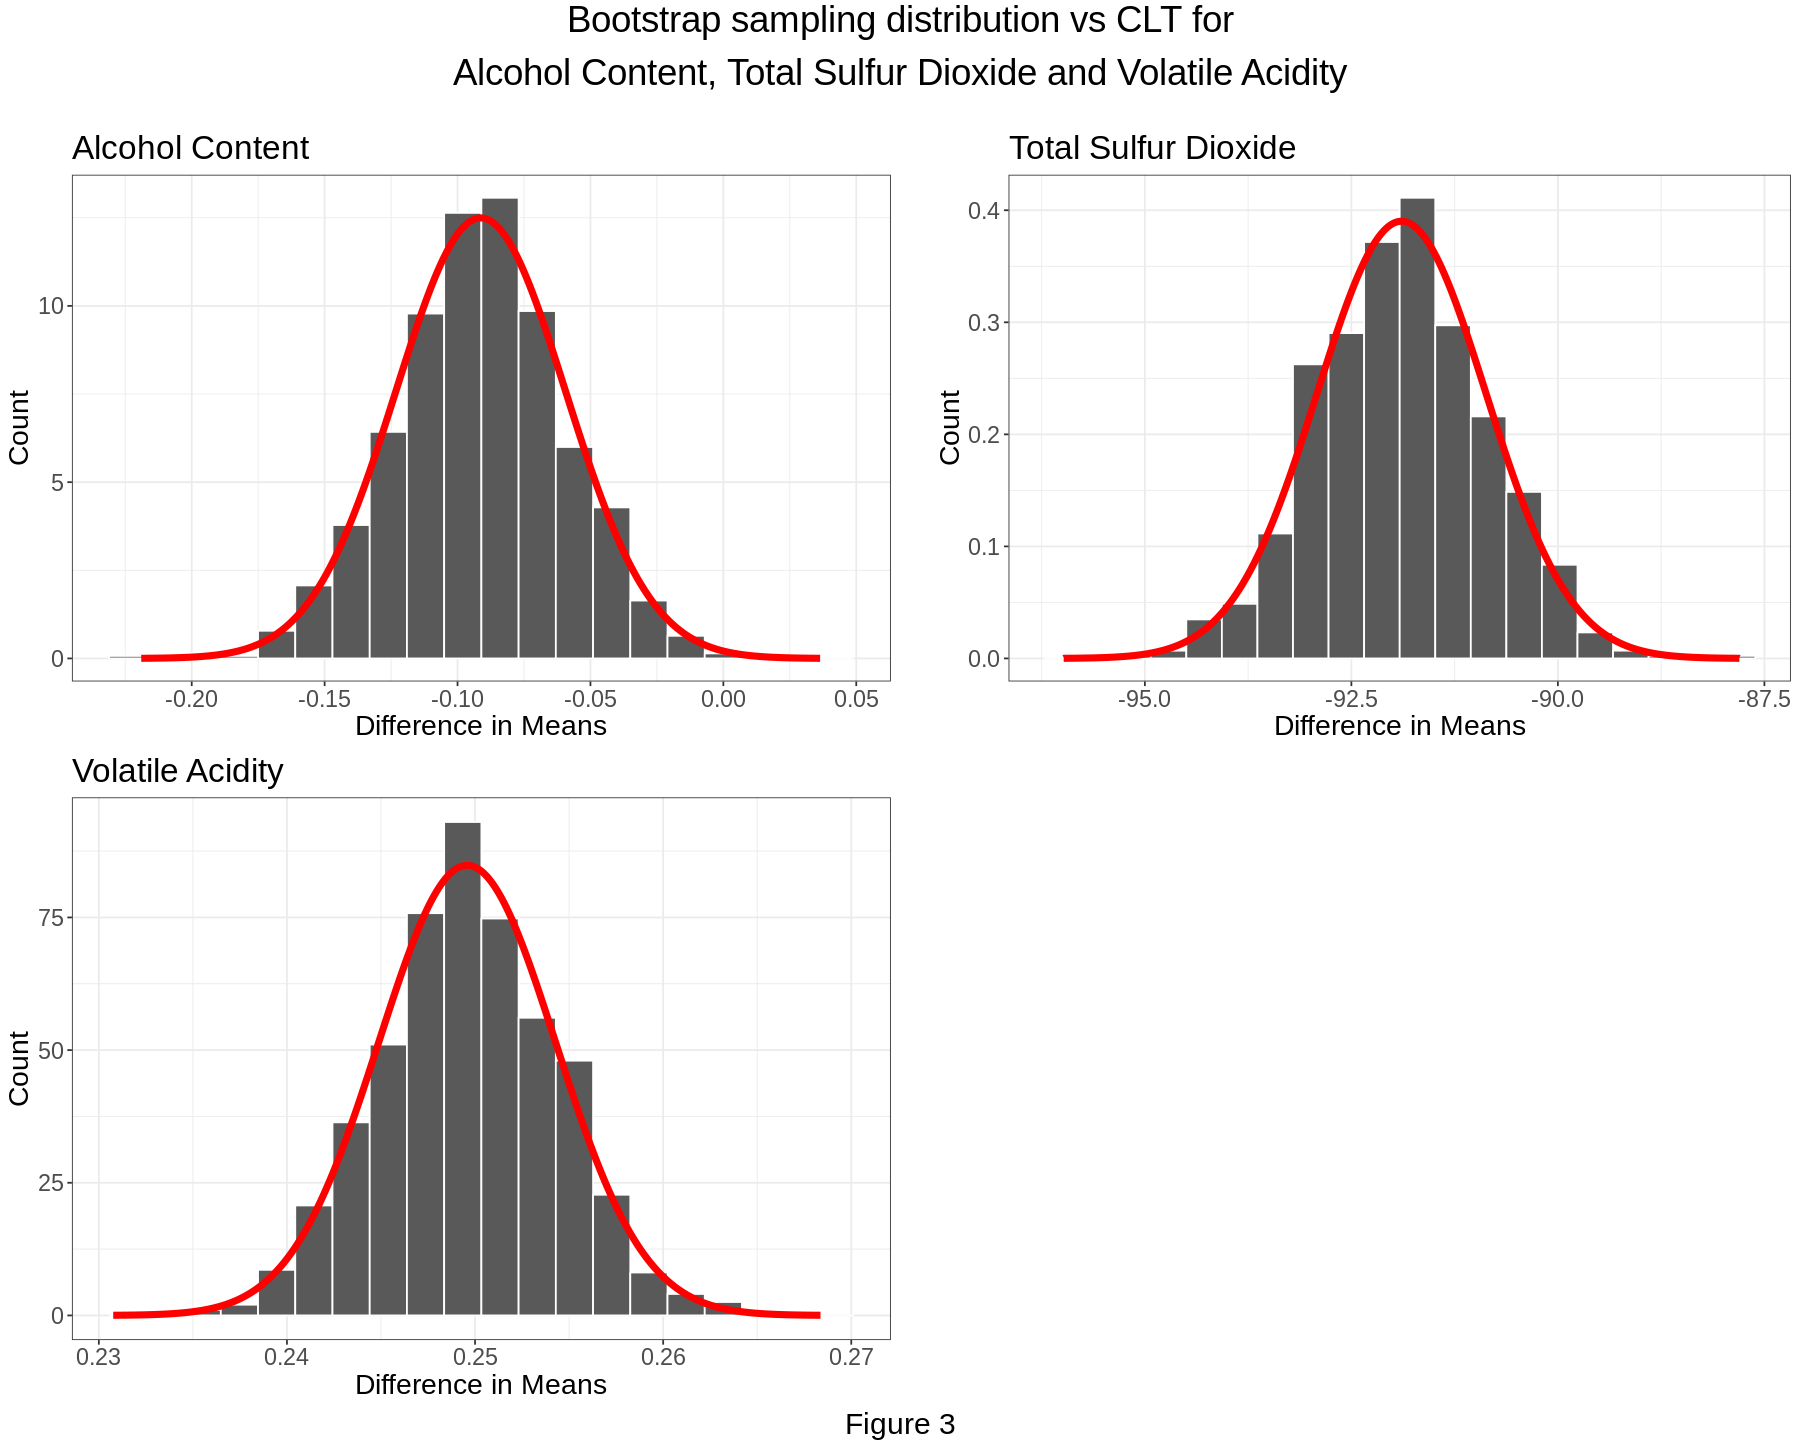

In [45]:
# set seed for consistent results
set.seed(420)
# set width and height of the plot for this cell
options(repr.plot.width=15, repr.plot.height=12)

## Bootstrap sampling distribution with the normal curve for mean difference in alcohol content
# Obtain the bootstrap sampling distribution for mean difference in alcohol content
diff_in_means_alcohol_bootstrap_dist <- 
    wine_data |>
    specify(formula = alcohol ~ type) |>
    generate(reps = 1000, type = "bootstrap") |>
    calculate(stat = "diff in means", order = c("red", "white")) 

# Plot the bootstrap sampling distribution vs the CLT estimates
diff_in_means_alcohol_plot <-
    diff_in_means_alcohol_bootstrap_dist |>
    ggplot() + 
    geom_histogram(aes(stat, ..density..), bins = 20, color = 'white') + 
    geom_line(data = clt_samp_dist_alcohol, aes(x, density), lwd = 2, color = "red") +
    theme(text = element_text(size = 20)) + 
    labs(x = "Difference in Means", y = "Count", title = "\nAlcohol Content") +
    theme_bw() +
    theme(axis.text=element_text(size=14),
          axis.title=element_text(size=17),
          plot.title = element_text(size=20))

## Bootstrap sampling distribution with the normal curve for mean difference in total sulfur dioxide
# Obtain the bootstrap sampling distribution for mean difference in total sulfur dioxide
diff_in_means_sulfur_bootstrap_dist <- 
    wine_data |>
    specify(formula = total.sulfur.dioxide ~ type) |>
    generate(reps = 1000, type = "bootstrap") |>
    calculate(stat = "diff in means", order = c("red", "white")) 

# Plot the bootstrap sampling distribution vs the CLT estimates
diff_in_means_sulfur_plot <-
    diff_in_means_sulfur_bootstrap_dist |>
    ggplot() + 
    geom_histogram(aes(stat, ..density..), bins = 20, color = 'white') + 
    geom_line(data = clt_samp_dist_sulfur, aes(x, density), lwd = 2, color = "red") +
    theme(text = element_text(size = 20)) + 
    labs(x = "Difference in Means", y = "\nCount", title = "\nTotal Sulfur Dioxide") +
    theme_bw() +
    theme(axis.text=element_text(size=14),
          axis.title=element_text(size=17),
          plot.title = element_text(size=20))


## Bootstrap sampling distribution with the normal curve for mean difference in volatile acidity
# Obtain the bootstrap sampling distribution for mean difference in volatile acidity
diff_in_means_acidity_bootstrap_dist <- 
    wine_data |>
    specify(formula = volatile.acidity ~ type) |>
    generate(reps = 1000, type = "bootstrap") |>
    calculate(stat = "diff in means", order = c("red", "white"))  

# Plot the bootstrap sampling distribution vs the CLT estimates
diff_in_means_acidity_plot <-
    diff_in_means_acidity_bootstrap_dist |>
    ggplot() +
    geom_histogram(aes(stat, ..density..), bins = 20, color = 'white') + 
    geom_line(data = clt_samp_dist_acidity, aes(x, density), lwd = 2, color = "red") +
    theme(text = element_text(size = 20)) + 
    labs(x = "Difference in Means", y = "Count", title = "Volatile Acidity") +
    theme_bw() +
    theme(axis.text=element_text(size=14),
          axis.title=element_text(size=17),
          plot.title = element_text(size=20))

# Group all 3 bootstrap sampling distribution vs CLT estimates plots together
grid.arrange(diff_in_means_alcohol_plot,
             diff_in_means_sulfur_plot,
             diff_in_means_acidity_plot,
             nrow = 2,
             ncol = 2,
             top = textGrob("Bootstrap sampling distribution vs CLT for\nAlcohol Content, Total Sulfur Dioxide and Volatile Acidity",
                            gp=gpar(fontsize=22)),
             bottom = textGrob("Figure 3",
                            gp=gpar(fontsize=18)))

### 2.2.2 Visualizing the 95% confidence intervals based on Bootstrapping

* Using `get_ci()` on the bootstrap distribution objects, we obtain 95% confidence interval for mean difference in `alcohol` across the two wine types.
* In order to visualize the confidence intervals, we use `visualize()` + `shade_confidence_interval()`  with `diff_in_means_alcohol_bootstrap_dist` and  `diff_in_means_alcohol_ci` as the arguments respectively.
* This is repeated for the other two response variables: `total.sulfur.dioxide` and `volatile.acidity`.

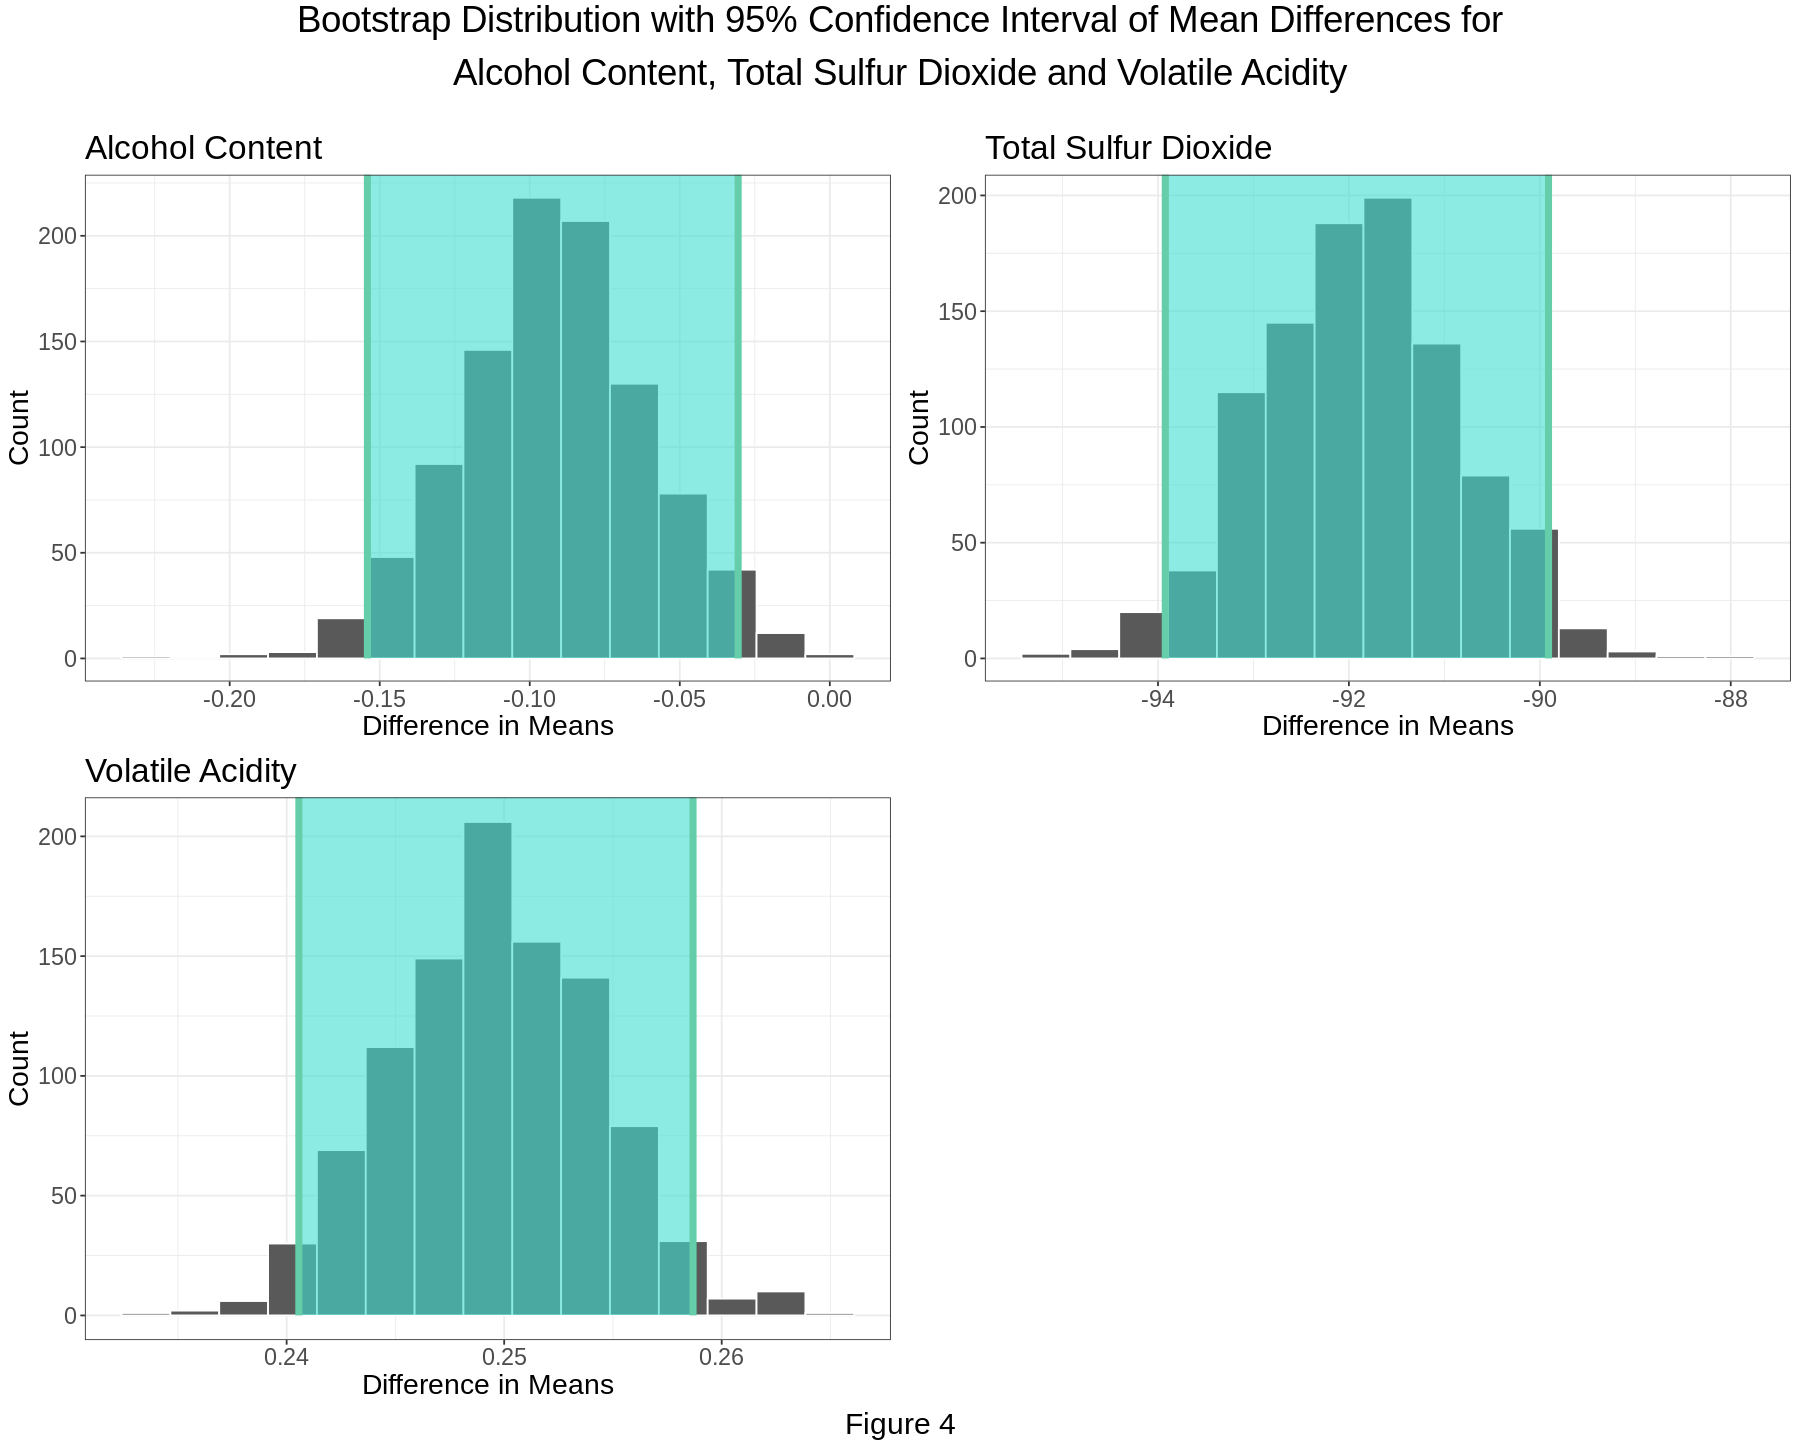

In [46]:
# set seed for consistent results
set.seed(420)
# set width and height of the plot for this cell
options(repr.plot.width=15, repr.plot.height=12)

# Using the boostrap distribution diff_in_means_alcohol_bootstrap_dist, find the 95% confidence interval with get_ci()
diff_in_means_alcohol_ci <- 
    diff_in_means_alcohol_bootstrap_dist |> 
    get_confidence_interval(level = 0.95, type = "percentile")

# Visualize the confidence interval diff_in_means_alcohol_ci with the bootstrap distribution diff_in_means_alcohol_bootstrap_dist
diff_in_means_alcohol_ci_plot <-
    visualize(diff_in_means_alcohol_bootstrap_dist) + 
    shade_confidence_interval(endpoints = diff_in_means_alcohol_ci) + 
    theme(text = element_text(size = 20)) + 
    labs(x = "Difference in Means", y = "Count", title = "\nAlcohol Content") +
    theme_bw() +
    theme(axis.text=element_text(size=14),
          axis.title=element_text(size=17),
          plot.title = element_text(size=20))

# Using the boostrap distribution diff_in_means_sulfur_bootstrap_dist, find the 95% confidence interval with get_ci()
diff_in_means_sulfur_ci <- 
    diff_in_means_sulfur_bootstrap_dist |> 
    get_confidence_interval(level = 0.95, type = "percentile")

# Visualize the confidence interval diff_in_means_sulfur_ci with the bootstrap distribution diff_in_means_sulfur_bootstrap_dist
diff_in_means_sulfur_ci_plot <-
    visualize(diff_in_means_sulfur_bootstrap_dist) + 
    shade_confidence_interval(endpoints = diff_in_means_sulfur_ci) + 
    theme(text = element_text(size = 20)) + 
    labs(x = "Difference in Means", y = "Count", title = "\nTotal Sulfur Dioxide") +
    theme_bw() +
    theme(axis.text=element_text(size=14),
          axis.title=element_text(size=17),
          plot.title = element_text(size=20))

# Using the boostrap distribution diff_in_means_acidity_bootstrap_dist, find the 95% confidence interval with get_ci()
diff_in_means_acidity_ci <- 
    diff_in_means_acidity_bootstrap_dist |> 
    get_confidence_interval(level = 0.95, type = "percentile")

# Visualize the confidence interval diff_in_means_acidity_ci with the bootstrap distribution diff_in_means_acidity_bootstrap_dist
diff_in_means_acidity_ci_plot <-
    visualize(diff_in_means_acidity_bootstrap_dist) + 
    shade_confidence_interval(endpoints = diff_in_means_acidity_ci) + 
    theme(text = element_text(size = 20)) + 
    labs(x = "Difference in Means", y = "Count", title = "Volatile Acidity") +
    theme_bw() +
    theme(axis.text=element_text(size=14),
          axis.title=element_text(size=17),
          plot.title = element_text(size=20))

# Group all 3 bootstrap sampling distribution with confidence intervals plot together
grid.arrange(diff_in_means_alcohol_ci_plot,
             diff_in_means_sulfur_ci_plot,
             diff_in_means_acidity_ci_plot,
             nrow = 2,
             ncol = 2,
             top = textGrob("Bootstrap Distribution with 95% Confidence Interval of Mean Differences for\nAlcohol Content, Total Sulfur Dioxide and Volatile Acidity",
                            gp=gpar(fontsize=22)),
             bottom = textGrob("Figure 4",
                            gp=gpar(fontsize=18)))


### 2.2.3 Obtaining confidence intervals based on Bootstrapping

* Combine all the 95% confidence intervals of mean differences for `alcohol`, `total.sulfur.dioxide` and `volatile.acidity` obtained from the bootstrap sampling distribution.

In [47]:
# Combine all the calculated 95% confidence intervals into a table displaying the CIs associated with each response variable
wine_diff_means_btsp_ci <- 
    diff_in_means_alcohol_ci |> 
    rbind(diff_in_means_sulfur_ci) |> 
    rbind(diff_in_means_acidity_ci) |>
    mutate(Response = names$response_variables) |>
    select(3,1,2)

wine_diff_means_btsp_ci

Response,lower_ci,upper_ci
<chr>,<dbl>,<dbl>
Alcohol Content,-0.1540946,-0.03054765
Total Sulfur Dioxide,-93.9233635,-89.90902776
Volatile Acidity,0.2405614,0.25868223


### 2.2.4 Obtaining confidence intervals based on the CLT

* Calculate all the 95% confidence intervals of mean differences for `alcohol`, `total.sulfur.dioxide` and `volatile.acidity` obtained by CLT.

In [48]:
# Estimate the difference in means using CLT
wine_diff_means_clt_ci <-
    stats |>
    group_by(Response) |>
    summarise(
        lower_ci_clt= mean_red - mean_white - qnorm(0.975) * sqrt(var_red/n_red + var_white/n_white),
        upper_ci_clt = mean_red - mean_white + qnorm(0.975) * sqrt(var_red/n_red + var_white/n_white)) |>
    mutate(Response = names$response_variables)

wine_diff_means_clt_ci

Response,lower_ci_clt,upper_ci_clt
<chr>,<dbl>,<dbl>
Alcohol Content,-0.1538623,-0.02870561
Total Sulfur Dioxide,-93.8968995,-89.88883055
Volatile Acidity,0.2403601,0.25879867


### 2.2.5 Comparing confidence intervals of Bootstrapping and CLT side-by-side

<table class="table" style="margin-left: auto; margin-right: auto;border-bottom: 0;">
<caption><center>Table 3: Confidence Intervals from Bootstrapping and CLT</center></caption>
 <thead>
<tr>
<th style="empty-cells: hide;border-bottom:hidden;" colspan="1"></th>
<th style="border-bottom:hidden;padding-bottom:0; padding-left:3px;padding-right:3px;text-align: center; font-weight: bold; font-style: italic; " colspan="2"><div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">Bootstrap</div></th>
<th style="border-bottom:hidden;padding-bottom:0; padding-left:3px;padding-right:3px;text-align: center; font-weight: bold; font-style: italic; " colspan="2"><div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">CLT</div></th>
</tr>
  <tr>
   <th style="text-align:left;"> Response Variable </th>
   <th style="text-align:center;"> Lower CI </th>
   <th style="text-align:center;"> Upper CI </th>
   <th style="text-align:center;"> Lower CI </th>
   <th style="text-align:center;"> Upper CI </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> Alcohol Content </td>
   <td style="text-align:center;"> -0.1541 </td>
   <td style="text-align:center;"> -0.0305 </td>
   <td style="text-align:center;"> -0.1539 </td>
   <td style="text-align:center;"> -0.0287 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Total Sulfur Dioxide </td>
   <td style="text-align:center;"> -93.9234 </td>
   <td style="text-align:center;"> -89.9090 </td>
   <td style="text-align:center;"> -93.8969 </td>
   <td style="text-align:center;"> -89.8888 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Volatile Acidity </td>
   <td style="text-align:center;"> 0.2406 </td>
   <td style="text-align:center;"> 0.2587 </td>
   <td style="text-align:center;"> 0.2404 </td>
   <td style="text-align:center;"> 0.2588 </td>
  </tr>
</tbody>
<tfoot>
<tr><td style="padding: 0; " colspan="100%"><span style="font-style: italic;">CI, confidence interval; CLT, Central Limit Theorem</span></td></tr>
<tr><td style="padding: 0; " colspan="100%">
<sup></sup> </td></tr>
</tfoot>
</table>

* We observe that the two confidence intervals obtained from Bootstrapping and CLT are extremely similar. However, we decide to choose the CLT method over bootstrapping because the parameter that we are estimating is the mean differences between each wine type. Since the CLT states that if the sample size is large enough and if the statistic drawn includes summations of random variables, the resulting sampling distribution will converge to an approximately normal distribution. In addition, since we do not know the variance of the normal distribution we have to estimate it. In order to account for the uncertainty, our sampling distribution of mean differences will follow a t-distribution with n-1 degrees of freedom.  
  
* On the other hand, bootstrapping is better suited for more unusual circumstances where the sample size may be very small or none of the normality assumptions are being met by the distribution of the statistic.

### 2.2.6 Two Sample t-test for Mean Differences

* Create two data frames: one with the selected response variables filtered for red wine and the other for white wine.
* PERFORM THE PAIRED T-TEST FOR EACH RESPONSE VARIABLE
    * `mapply()` helps us to apply a function to the first elements of each argument, the second elements, the third elements, and so on. Since the order of both the data frames are identical in terms of variable names, this means that we can perform the `t.test` on three different variables at once. 
    * We use `t.test()` as the function in `mapply()`. We also make use of the `tidy()` function part of the `broom` package which provides the results in a tidy format.
    * Since we are using a two sided test we set `alternative = "two.sided"`.
    * After setting up the `t.test()` function, the `red_wine` data frame is inputted as the 2nd argument and the `white_wine` data frame as the 3rd argument for the `mapply()` function.
    * Manipulate the resultant data to extract the individual estimates, confidence intervals and p-values obtained from each two sample t-test.
* Create the `test_table` object to represent the results in a tidy format.

In [20]:
# Create a dataframe with the selected response variables for red wine
red_wine <-
    wine_data |>
    filter(type == "red") |>
    select(alcohol, total.sulfur.dioxide, volatile.acidity)

# Create a dataframe with the selected response variables for white wine
white_wine <-
    wine_data |>
    filter(type == "white") |>
    select(alcohol, total.sulfur.dioxide, volatile.acidity)

## PERFORM THE PAIRED T-TEST FOR EACH RESPONSE VARIABLE
t_test_results <-
  mapply(function(x, y) broom::tidy(t.test(x, y,
                               alternative = "two.sided",
                               na.action = na.omit)),
                  red_wine,
                  white_wine) |>
  as.data.frame() |> 
  rownames_to_column() |> 
  filter(rowname %in% c("p.value", "estimate", "conf.low", "conf.high")) |>
  pivot_longer(alcohol:volatile.acidity,
               names_to = "variable",
               values_to = "value") |>
  pivot_wider(names_from = rowname,
              values_from = value) |> 
  mutate(estimate = lapply(estimate, function(x) toString(x) |> parse_number()),
         conf.low = lapply(conf.low, function(x) format(round(x, 3), nsmall = 3)),
         conf.high = lapply(conf.high, function(x) format(round(x, 3), nsmall = 3)),
         p.value = p.value) |> 
  select(estimate, conf.low, conf.high, p.value) |>
  unnest(cols = c("p.value", "estimate")) |>
  mutate_if(is.numeric, function(x) format(round(x, 3), nsmall = 3))

# Create the table with all the results for the 2 sample t-test
test_table <- names |>
  cbind(t_test_results) |>
  mutate(conf.int = paste0("[", conf.low, ", ", conf.high, "]")) |>
  select(c(1, 2, 6, 5))

<table class="table" style="margin-left: auto; margin-right: auto;border-bottom: 0;">
<caption><center>Table 4: Two sample t-test used to evaluate the differences in means between red and white wine for each of the selected response variable</center></caption>
 <thead>
<tr>
<th style="empty-cells: hide;border-bottom:hidden;" colspan="1"></th>
<th style="border-bottom:hidden;padding-bottom:0; padding-left:3px;padding-right:3px;text-align: center; font-weight: bold; " colspan="3"><div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">2 Sample t-test</div></th>
</tr>
  <tr>
   <th style="text-align:left;"> Response Variable </th>
   <th style="text-align:right;"> Mean difference </th>
   <th style="text-align:center;"> 95% Confidence Interval </th>
   <th style="text-align:left;"> P-value </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> Alcohol Content </td>
   <td style="text-align:right;"> -0.091 </td>
   <td style="text-align:center;"> [-0.154, -0.029] </td>
   <td style="text-align:left;"> 0.004 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Total Sulfur Dioxide </td>
   <td style="text-align:right;"> -91.893 </td>
   <td style="text-align:center;"> [-93.898, -89.888] </td>
   <td style="text-align:left;"> &lt; .0001 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Volatile Acidity </td>
   <td style="text-align:right;"> 0.250 </td>
   <td style="text-align:center;"> [0.240, 0.259]  </td>
   <td style="text-align:left;"> &lt; .0001 </td>
  </tr>
</tbody>
<tfoot>
<tr><td style="padding: 0; " colspan="100%"><span style="font-style: italic;">Note:</span></td></tr>
<tr><td style="padding: 0; " colspan="100%">
<sup>1</sup> P-values less than 0.05 are regarded as statistically significant, leading to rejection of the null hypothesis that the expected differences are zero; </td></tr>
<tr><td style="padding: 0; " colspan="100%">
<sup>2</sup> P-values less than 0.01 are regarded as highly statistically significant; </td></tr>
<tr><td style="padding: 0; " colspan="100%">
<sup>3</sup> P-values greater than 0.05 indicate that there is insufficient evidence to reject the null hypothesis</td></tr>
</tfoot>
</table>



### 2.2.7 Visualizing the hypothesis test for each response variable

* Generate the null distribution for difference in means of alcohol content using `specify()` + `hypothesise()` + `generate()` + `calculate()`.
* Visualize the null distribution of the mean difference of alcohol content using `visualize()`. In addition, shade the p-values and represent the p-value itself using a vertical red line.
* Repeat this for the other two response variables: `total.sulfur.dioxide` and `volatile.acidity`.

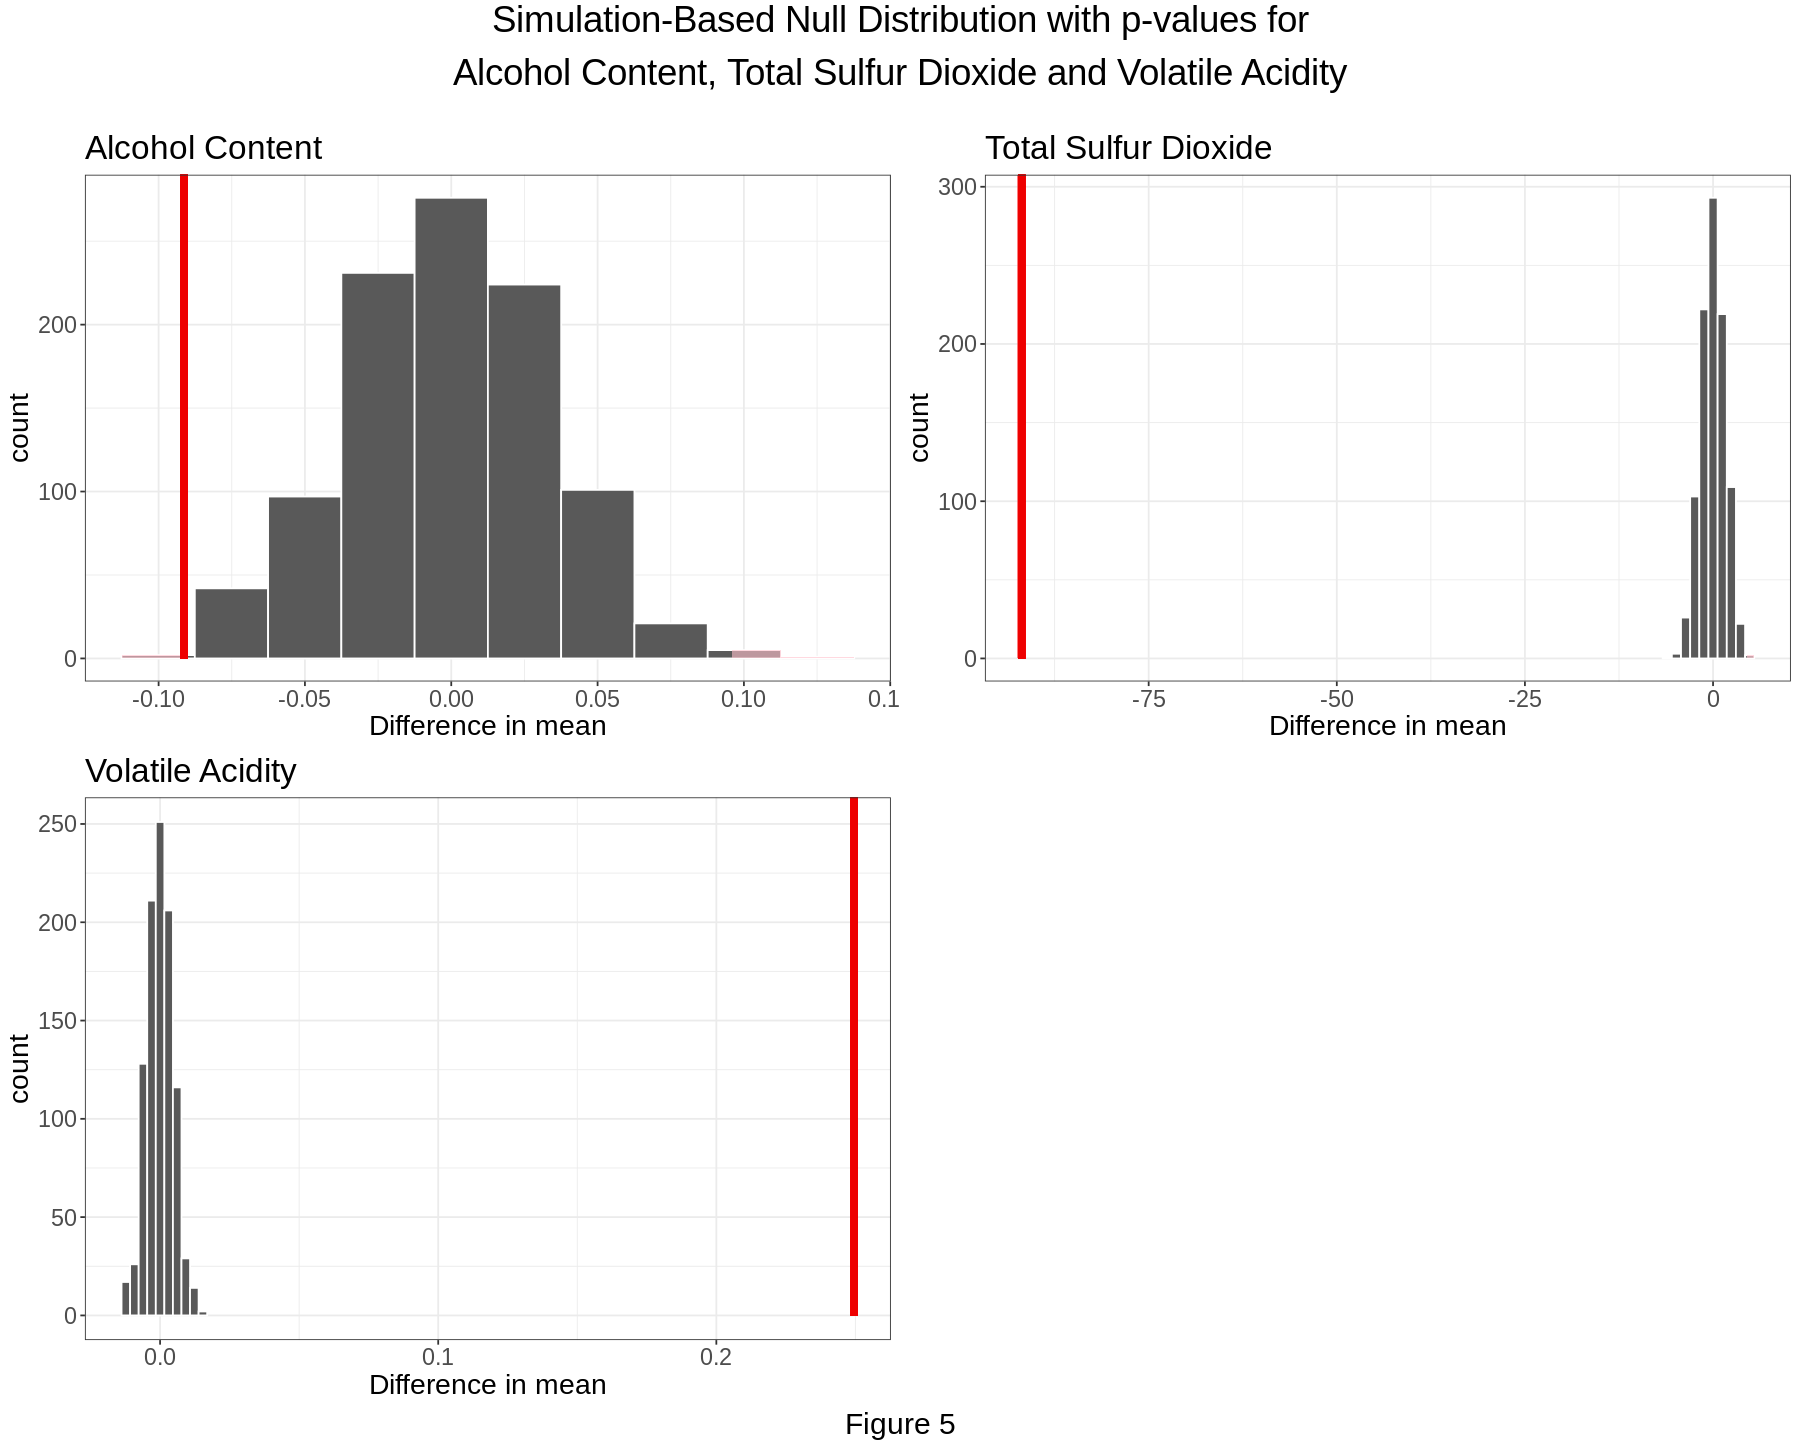

In [49]:
# set seed for consistent results
set.seed(420)
# set width and height of the plot for this cell
options(repr.plot.width=15, repr.plot.height=12)

###################################################
## VISUALIZATION OF THE HYPOTHESIS TEST FOR ACLCOHOL CONTENT
# Obtain the test statistic (difference in means) for alcohol content
obs_diff_in_means_alcohol <- 
    wine_data |> 
    specify(formula = alcohol ~ type) |>
    calculate(stat = "diff in means", order = c("red", "white"))

# Generate the null distribution for mean differences in alcohol content
null_diff_in_means_alcohol <- 
    wine_data |>
    specify(formula = alcohol ~ type) |> 
    hypothesise(null = "independence") |> 
    generate(type = "permute", reps = 1000) |> 
    calculate(stat = "diff in means", order = c("red", "white"))

# Visualize the null distribution and shade the p-value
# Put a vertical bar for the observed test statistic obs_diff_in_means
diff_in_means_plot_alcohol <-
    visualize(null_diff_in_means_alcohol, bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means_alcohol, direction = "both") +
    labs(x = "Difference in mean", title = "\nAlcohol Content") +
    theme_bw() +
    theme(axis.text=element_text(size=14),
          axis.title=element_text(size=17),
          plot.title = element_text(size=20))

###################################################
## VISUALIZATION OF THE HYPOTHESIS TEST FOR TOTAL SULFUR DIOXIDE
# Obtain the test statistic (difference in means) for total sulfur dioxide
obs_diff_in_means_sulfur <- 
    wine_data  %>% 
    specify(formula = total.sulfur.dioxide ~ type) %>%
    calculate(stat = "diff in means", order = c("red", "white"))

# Generate the null distribution for mean differences in total sulfur dioxide
null_diff_in_means_sulfur <- 
    wine_data %>% 
    specify(formula = total.sulfur.dioxide ~ type) %>% 
    hypothesise(null = "independence") %>% 
    generate(type = "permute", reps = 1000) %>% 
    calculate(stat = "diff in means", order = c("red", "white"))

# Visualize the null distribution and shade the p-value
# Put a vertical bar for the observed test statistic obs_diff_in_means
diff_in_means_plot_sulfur <-
    visualize(null_diff_in_means_sulfur, bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means_sulfur, direction = "both") +
    labs(x = "Difference in mean", title = "\nTotal Sulfur Dioxide") +
    theme_bw() +
    theme(axis.text=element_text(size=14),
          axis.title=element_text(size=17),
          plot.title = element_text(size=20))

###################################################
## VISUALIZATION OF THE HYPOTHESIS TEST FOR VOLATILE ACIDITY
# Obtain the test statistic (difference in means) for volatile acidity
obs_diff_in_means_acidity <- 
    wine_data  %>% 
    specify(formula = volatile.acidity ~ type) %>%
    calculate(stat = "diff in means", order = c("red", "white"))

# Generate the null distribution for mean differences in alcohol content
null_diff_in_means_acidity <- 
    wine_data %>% 
    specify(formula = volatile.acidity ~ type) %>% 
    hypothesise(null = "independence") %>% 
    generate(type = "permute", reps = 1000) %>% 
    calculate(stat = "diff in means", order = c("red", "white"))

# Visualize the null distribution and shade the p-value
# Put a vertical bar for the observed test statistic obs_diff_in_means
diff_in_means_plot_acidity <-
    visualize(null_diff_in_means_acidity, bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means_acidity, direction = "both") +
    labs(x = "Difference in mean", title = "Volatile Acidity") +
    theme_bw() +
    theme(axis.text=element_text(size=14),
          axis.title=element_text(size=17),
          plot.title = element_text(size=20))

# Arrange all the visualizations together
grid.arrange(diff_in_means_plot_alcohol,
             diff_in_means_plot_sulfur,
             diff_in_means_plot_acidity,
             nrow = 2,
             ncol = 2,
             top = textGrob("Simulation-Based Null Distribution with p-values for\nAlcohol Content, Total Sulfur Dioxide and Volatile Acidity",
                            gp=gpar(fontsize=22)),
             bottom = textGrob("Figure 5",
                            gp=gpar(fontsize=18)))

## 3. Discussion

### 3.1 Asymptotics vs Bootstrap

Acknowledging the sampling distribution and confidence intervals in 2.2.1 and 2.2.5 respectively, this report suggests that the two methods produce extremely similar results. The plots overlap and the numbers are nearly identical. In the context of this report, it would not have mattered which method was used. Outside of the scope of this course, the [bias-variance trade-off](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229) is a property explaining CLT as the more accurate of the two because we are adding the “bias” that the model follows a t distribution; however, as evident in this report, with the minute, certain sections such as 2.2.7 focused on the bootstrap method to be more interpretable to the reader being intuitively generated as opposed to being from a asymptotic model.


### 3.2 Confidence intervals and T-test

From the results of our two-sample t-tests for difference in mean contents of alcohol, sulfur dioxide, and volatile acidity, we can see that although all three tests were statistically significant, it is extremely evident that the difference in means of sulfur dioxide and volatile acidity are much more significant (p-value < 0.0001) than the difference in means of alcohol (p-value 0.004). This finding mirrors the results in our confidence intervals for the same variables: the relatively higher p-value of alcohol is reflected in the way its confidence interval is much closer to 0 (the null) in comparison to the confidence intervals of sulfur dioxide and volatile acidity, which are extremely far from 0, hence their extremely low p-values. It should also be noted that for the confidence intervals, we used a 95% significance level, which shows the range of values in which we are 95% confident that would capture the true value of difference in means of alcohol, sulfur dioxide, and volatile acidity.


### Explaining the Differences in Variables (T test results p-value)

From our data, there is an extremely significant difference in the mean levels of sulfur-dioxide between red and white wine. External research suggests that this is due to white wine’s way of compromising for their lack of tannin, an astringent compound most commonly found on grape skin, since white wine is fermented with the grape skins peeled off. Further, tannin is red wine’s primary protection against wine spoilage and oxidation during the aging process. Therefore, in order for white wine to have a similar ability to combat spoilage and oxidation, extra sulfur dioxide is usually added to preserve the wine and prevent oxidation and browning in the absence of tannin, hence the observed higher sulfur dioxide levels in white wine.  
  
From external research, many studies have found that red wines exhibit a slightly higher alcohol by volume (ABV) than white wine, which is usually due to the difference in time/season the grapes are harvested depending on the type of wine. Red wines are made with grapes harvested late in the season with more sugar than the grapes used in white wines – leading to red wine having a higher alcohol concentration. However, this contradicts our findings, since our data suggests that white wine has a higher alcohol content than red wine. As we do not know exactly how and where the wine data is retrieved, we cannot say for sure whether the dataset contains incorrect or biased data. Further research needs to be conducted to find out exactly why and how our data contradicts common research.  
Although sources claim that white wine is more acidic than red wine, our data suggests that red wine has higher volatile acidity than white wine. This discrepancy can be explained by the types of acids included in the measurement of volatile acidity. For example, the measurement of volatile acidity only considers gaseous acids that contribute to the smell and taste of vinegar in wine, most commonly acetic acid. Therefore, although red wine may be less acidic overall, they may contain more acids that fit the volatile acidity criteria than white wine. This observation is also supported by the fact that the maximum volatile acidity cap set by the Code of Federal Regulations on red wine is higher (0.14 g/100 mL) than for white wine (0.12 g/100 mL).


## Conclusion

To summarize and conclude our findings, we observed that the p-value for the mean differences of Alcohol Content, Total Sulfur Dioxide, and Volatile Acidity are highly statistically significant therefore we reject the null hypotheses for each of these variables. In conclusion, red and white wine have different amounts of alcohol, sulfur dioxide, and volatile acidity. Through an effort to explain our statistical findings through qualitative external research, only the sulfur dioxide discrepancy had a firm, logical explanation, whereas the alcohol and volatile acidity discrepancy requires further research to explain the possible contradictions between our findings and the external research conducted on its relevant topics. All in all, this research was only made possible through the use of statistical inference, which allowed us to not only to prove the existence of inherent differences between red and white wine outside of a simple visual comparison, but also enabled us to connect these findings to external research to explore the reasoning behind such differences.

## References

Bell, T. (2020, November 2). Which wine is most acidic? DrinkWell. https://drinkwelluk.com/blogs/news/which-wine-is-most-acidic
 
Everything You Need to Know About Tannins in Wine. (2020, February 24). Usual. https://usualwines.com/blogs/knowledge-base/tannins-in-wine
 
Gardner, D. M. (2022, March 24). Volatile Acidity in Wine. Penn State Extension. https://extension.psu.edu/volatile-acidity-in-wine
 
Kreiehl Mw, A. (2018, September 11). What are Tannins, Really? Wine Enthusiast. https://www.winemag.com/2018/09/11/tannins-wine-guide/

[Red and White Wine]. (n.d.-a). Wine Cooler Direct. https://learn.winecoolerdirect.com/wp-content/uploads/2020/04/Red-and-White-Wine-opt.jpg

[Red and White Wine]. (n.d.-b). Onmanorama. https://img.onmanorama.com/content/dam/mm/en/food/in-season/images/2019/11/8/wine.jpg
 
Singh, S. (2022, February 18). Understanding the Bias-Variance Tradeoff - Towards Data Science. Medium. https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229
 
Sulphur Levels in Wine – Grape to Glass. (n.d.). Grape to Glass. https://grape-to-glass.com/index.php/sulphur-levels-wine/
 
UCI Machine Learning Repository: Wine Quality Data Set. (n.d.). UCI. https://archive.ics.uci.edu/ml/datasets/wine+quality
 
Wine Alcohol Content: How Much Alcohol is in Wine? (n.d.). Binwise. https://home.binwise.com/blog/wine-alcohol-content
